# Project 3: Pushshift's API WebScrapping for Predicting Comments and Modeling

- In this project, collecting data via an API request and then building a binary predictor. As we discussed in the data science course, there are two components to starting a data science problem: the problem statement, and acquiring the data.

- Our problem statement will be: What characteristics of a post on Pushshift's API contribute most to the overall interaction of comments?

In [1]:
import requests
# importing Necessary Library
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import time
import datetime as dt
import re
from bs4 import BeautifulSoup

import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV


# setting the visual
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline     

In [2]:
pwd

'/Users/derejeworkneh/Documents/dsi/Submission_DSI_11/Project3'

In [3]:
url = 'https://api.pushshift.io/reddit/search/submission'

In [4]:
# headers of 'User-agent' is required if you don't
# want a 429 error as it limits your returns.
headers= ({'User-agent': 'Dereje Bot 0.1'})

In [5]:
params = {
    'subreddit': 'physics',
    'size': 500,
    'before': 1587442292
}

In [6]:
res = requests.get(url, headers=headers)    # Sending an HTTP request with URL and the Requesting agent as header

In [7]:

res.status_code

200

In [8]:
res = requests.get(url, params)

In [9]:
# return the requested page into a json object
data = res.json()  

In [10]:
posts = data['data']

In [11]:
posts

[{'all_awardings': [],
  'allow_live_comments': False,
  'author': 'ERT3690',
  'author_flair_css_class': None,
  'author_flair_richtext': [],
  'author_flair_text': None,
  'author_flair_type': 'text',
  'author_fullname': 't2_69cgadek',
  'author_patreon_flair': False,
  'author_premium': False,
  'awarders': [],
  'can_mod_post': False,
  'contest_mode': False,
  'created_utc': 1587441012,
  'domain': 'self.Physics',
  'full_link': 'https://www.reddit.com/r/Physics/comments/g58200/专注海外教育服务_qq微信2228960192_诚信制作dartmouth毕业证/',
  'gildings': {},
  'id': 'g58200',
  'is_crosspostable': False,
  'is_meta': False,
  'is_original_content': False,
  'is_reddit_media_domain': False,
  'is_robot_indexable': False,
  'is_self': True,
  'is_video': False,
  'link_flair_background_color': '',
  'link_flair_richtext': [],
  'link_flair_text_color': 'dark',
  'link_flair_type': 'text',
  'locked': False,
  'media_only': False,
  'no_follow': True,
  'num_comments': 0,
  'num_crossposts': 0,
  'over

In [12]:
data.keys()

dict_keys(['data'])

In [13]:
def pushshift(subreddit, post_type='submission', loops=1, size=500, skip=30):
# subreddit: str, name of subreddit to search for
# post_type: {'submission', 'comment'}, type of post to search for
# loops: int, number of times to request posts
# size: int, number of posts per request (max 500 per pushshift api guide)
# skip: int, number of days back to search in each loop 
        # increase if too many duplicate posts are returned, decrease if you want to skip fewer posts

    # data fields to return for submissions
    subfields = ['author', 'author_fullname', 'created_utc', 'id', 'num_comments', 'permalink', 
                 'score', 'selftext', 'subreddit', 'title', 'url', 'is_self']    
    # data fields to return for comments
    comfields = ['author', 'author_fullname', 'body', 'created_utc', 'id', 'parent_id', 
                'permalink', 'score', 'subreddit']
    # instantiate list for posts data
    list_posts = [] 
    #url_stem = "https://api.pushshift.io/reddit/search/submission/{}/?subreddit={}&size={}".format(post_type, subreddit, size)
    #url_stem = "https://api.pushshift.io/reddit/search/submission".format(post_type, subreddit, size)
    url_stem = "https://api.pushshift.io/reddit/search/{}/?subreddit={}&size={}".format(post_type, subreddit, size)
    
    # skip a minimum of 1 day
    after = 1    

    # check before requesting data
    if post_type not in ['submission', 'comment']:
        print("post_type must be 'submission' or 'comment'")
        return None
    
    for i in range(loops):
        # add parameters to url to skip posts (after could be used to match up to post at end of previous loop if skip = 0)
        url = '{}&after={}d'.format(url_stem, skip * i + after) 
        # monitor status as loops run
        print(i, url)
        # get data
        res = requests.get(url)
        # add dictionaries for posts to list_posts
        list_posts.extend(res.json()['data']) 
        # be polite
        time.sleep(1) 
        # turn list_posts (a list of dictionaries where each dictionary contains data on one post) into a dataframe
    df_posts = pd.DataFrame.from_dict(list_posts) 

    # filter fields for submissions or comments
    if post_type == 'submission':
        df_posts = df_posts[subfields]
    elif post_type == 'comment':
        df_posts = df_posts[comfields]  
#     else:
#         print("post_type must be 'submission' or 'comment'")
#         return None

    # drop any duplicates
    df_posts.drop_duplicates(inplace=True)
    # add a field identifying submissions or comments
    df_posts['post_type'] = post_type
    
    return df_posts
# Code adapted from gA DSI office hours with Tim Book.

In [14]:
physics_subs = pushshift('physics', post_type='submission', loops=20, skip=1)
print('shape', physics_subs.shape)
physics_subs.to_csv('physics_subs-pushshift.csv')

0 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=1d
1 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=2d
2 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=3d
3 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=4d
4 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=5d
5 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=6d
6 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=7d
7 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=8d
8 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=9d
9 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=10d
10 https://api.pushshift.io/reddit/search/submission/?subreddit=physics&size=500&after=11d
11 https://api.pus

In [15]:
chemistry_subs = pushshift('chemistry', post_type='submission', loops=21, skip=30)
print('shape', chemistry_subs.shape)
chemistry_subs.to_csv('chemistry_subs-pushshift.csv')

0 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&size=500&after=1d
1 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&size=500&after=31d
2 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&size=500&after=61d
3 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&size=500&after=91d
4 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&size=500&after=121d
5 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&size=500&after=151d
6 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&size=500&after=181d
7 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&size=500&after=211d
8 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&size=500&after=241d
9 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&size=500&after=271d
10 https://api.pushshift.io/reddit/search/submission/?subreddit=chemistry&s

In [16]:
physics_coms = pushshift('physics', post_type='comment', loops=20, skip=1)
print('shape', physics_coms.shape)
physics_coms.to_csv('physics_coms-pushshift.csv')

0 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=1d
1 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=2d
2 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=3d
3 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=4d
4 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=5d
5 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=6d
6 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=7d
7 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=8d
8 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=9d
9 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=10d
10 https://api.pushshift.io/reddit/search/comment/?subreddit=physics&size=500&after=11d
11 https://api.pushshift.io/reddit/search/comment/?

In [17]:
chemistry_coms = pushshift('chemistry', post_type='comment', loops=20, skip=1)
print('shape', chemistry_coms.shape)
chemistry_coms.to_csv('chemistry_coms-pushshift.csv')

0 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=1d
1 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=2d
2 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=3d
3 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=4d
4 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=5d
5 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=6d
6 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=7d
7 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=8d
8 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=9d
9 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=10d
10 https://api.pushshift.io/reddit/search/comment/?subreddit=chemistry&size=500&after=11d
11 https://api.pushshift.io/r

In [18]:
physics_subs.head(5)

,author,author_fullname,created_utc,id,num_comments,permalink,score,selftext,subreddit,title,url,is_self,post_type
0,PhDnPhysics,t2_6aee7wbo,1587677684,g6vgsv,0,/r/Physics/comments/g6vgsv/im_phd_physicist_ji...,1,[removed],Physics,Im PhD physicist Jim Peebles. AMA!,https://www.reddit.com/r/Physics/comments/g6vg...,True,submission
1,qtc0,t2_177njn,1587680139,g6w76a,7,/r/Physics/comments/g6w76a/gravitational_waves...,1,,Physics,Gravitational Waves and Prospects for Multi-me...,https://livestream.com/oxuni/barish/videos/193...,False,submission
2,internalDesign,t2_16uqsk,1587681270,g6wj2p,4,/r/Physics/comments/g6wj2p/stephen_wolfram_the...,1,[https://www.youtube.com/watch?v=acUf7PuGWXA]...,Physics,Stephen Wolfram (the daddy of wolfram alpha) t...,https://www.reddit.com/r/Physics/comments/g6wj...,True,submission
3,gabbyprk,t2_68cg72ut,1587681574,g6wm52,2,/r/Physics/comments/g6wm52/pressure/,1,Find the pressure exerted by a waterbed with d...,Physics,Pressure !!,https://www.reddit.com/r/Physics/comments/g6wm...,True,submission
4,ofe4,t2_z8on3,1587683022,g6x0z7,2,/r/Physics/comments/g6x0z7/many_worlds/,1,"if the many worlds theory is real, why would t...",Physics,many worlds,https://www.reddit.com/r/Physics/comments/g6x0...,True,submission


In [19]:
chemistry_subs.head(5)

,author,author_fullname,created_utc,id,num_comments,permalink,score,selftext,subreddit,title,url,is_self,post_type
0,NecessaryEffective,t2_ybdze7j,1587677215,g6vbnb,12,/r/chemistry/comments/g6vbnb/why_do_nearly_all...,1,After 6 years of University and 2 years as a r...,chemistry,Why Do Nearly All Entry-Level Jobs Require Unr...,https://www.reddit.com/r/chemistry/comments/g6...,True,submission
1,O___7,t2_62xgguu4,1587677782,g6vhur,3,/r/chemistry/comments/g6vhur/i_feel_like_there...,1,is it safe if i do the following:\n\nuse Everc...,chemistry,i feel like there is a simple answer to this b...,https://www.reddit.com/r/chemistry/comments/g6...,True,submission
2,Enquandriant,t2_mneie,1587683154,g6x2ag,7,/r/chemistry/comments/g6x2ag/recommendations_f...,1,I am taking a class on the synthesis of comple...,chemistry,Recommendations for a pharmaceutical total syn...,https://www.reddit.com/r/chemistry/comments/g6...,True,submission
3,GabrielDAreddit,t2_6ag6pcui,1587689336,g6yrcv,0,/r/chemistry/comments/g6yrcv/i_need_help_iupac/,1,[removed],chemistry,I NEED HELP (IUPAC),https://www.reddit.com/r/chemistry/comments/g6...,True,submission
4,inquisitive_narwhal,t2_3hej0e1w,1587689979,g6yxgc,2,/r/chemistry/comments/g6yxgc/studying_organic_...,1,"Hi everyone, I'm currently studying organic ch...",chemistry,Studying organic chemistry II online with Thom...,https://www.reddit.com/r/chemistry/comments/g6...,True,submission


In [20]:
physics_coms.head(5)

,author,author_fullname,body,created_utc,id,parent_id,permalink,score,subreddit,post_type
0,Schnilbert,t2_2f5ewvo8,You deserve the dad of the year award!,1587676170,focuskz,t1_foakquv,/r/Physics/comments/g6l0bg/i_wrote_about_keple...,3,Physics,comment
1,SourLolly,t2_19gqhw4o,"I'm a layman and I found his article exciting,...",1587678253,fod0bou,t3_g6n84j,/r/Physics/comments/g6n84j/why_stephen_wolfram...,2,Physics,comment
2,AsAChemicalEngineer,t2_4er7g,"Oh mah god, the article was worth it just for ...",1587678392,fod0ovd,t3_g6n84j,/r/Physics/comments/g6n84j/why_stephen_wolfram...,3,Physics,comment
3,PeachDrinkz,t2_1ls4fp2q,I learned in third year Physics that the reaso...,1587679046,fod2jxo,t3_g5ew2s,/r/Physics/comments/g5ew2s/physics_questions_t...,1,Physics,comment
4,vordigan1,t2_lvowucr,The only right and moral approach is to give u...,1587679447,fod3olx,t3_g6n84j,/r/Physics/comments/g6n84j/why_stephen_wolfram...,-3,Physics,comment


In [21]:
chemistry_coms.head(10)

,author,author_fullname,body,created_utc,id,parent_id,permalink,score,subreddit,post_type
0,pap0r0,t2_5g2yyizr,"yeah, you would underestimate how much technol...",1587676428,focvhn8,t1_foctoxa,/r/chemistry/comments/g6uhtb/can_someone_with_...,2,chemistry,comment
1,Seicair,t2_692nw,“Never sniff your chemicals!” Opened a tiny vi...,1587676447,focvjkm,t1_foc3twm,/r/chemistry/comments/g6paaf/just_recrystalliz...,4,chemistry,comment
2,Seicair,t2_692nw,"&gt; tiny rupee \n\nNice, I got one shaped the...",1587676557,focvu6p,t1_focn9ov,/r/chemistry/comments/g6paaf/just_recrystalliz...,3,chemistry,comment
3,Klipse11,t2_zu00k,Rick and Morty portal!,1587676627,focw1b1,t3_g6paaf,/r/chemistry/comments/g6paaf/just_recrystalliz...,2,chemistry,comment
4,Zeratule143,t2_ho884,"I just have to mention it had aloe in it, whic...",1587676832,focwlbh,t1_focousk,/r/chemistry/comments/g6tz6u/is_this_hand_sani...,1,chemistry,comment
5,theBASTman,t2_3xco2ac9,You are right. I remember once I had to do a r...,1587676852,focwn43,t1_focvjkm,/r/chemistry/comments/g6paaf/just_recrystalliz...,2,chemistry,comment
6,theBASTman,t2_3xco2ac9,Yes! Nice observation!,1587676878,focwpq5,t1_focw1b1,/r/chemistry/comments/g6paaf/just_recrystalliz...,2,chemistry,comment
7,Zeratule143,t2_ho884,Class action baby!,1587676949,focwwbn,t1_focssom,/r/chemistry/comments/g6tz6u/is_this_hand_sani...,1,chemistry,comment
8,Seicair,t2_692nw,...where was your fume hood? I try and avoid o...,1587677309,focxub1,t1_focwn43,/r/chemistry/comments/g6paaf/just_recrystalliz...,3,chemistry,comment
9,Skensis,t2_8dmb1,Bay area (USA) is a lot more home expensive th...,1587677869,foczbfy,t1_focug2t,/r/chemistry/comments/g6sicq/typical_salary_fo...,1,chemistry,comment


## Create csv for analysis of comment body text only¶

In [22]:
df = pd.concat([physics_coms[['body', 'subreddit']], chemistry_coms[['body', 'subreddit']]], ignore_index=True)
df.to_csv('comments.csv', index=False)

In [23]:
physics_coms['id'].value_counts()    # this will help us to see if there is repetition on the titles
# can also show how many times we have scrapped  from this id of the reddit
# However, this i found out there are multiple topics

fmzlk6z    1
fn1vvc5    1
fmlmomb    1
fmvmz76    1
fnsib7o    1
          ..
fo4d6z9    1
fn9yg7g    1
fmz0tjt    1
fmkj3ju    1
fob2thv    1
Name: id, Length: 6012, dtype: int64

In [24]:
chemistry_coms['id'].value_counts()

fnnila2    1
fmjsc03    1
fn48ie2    1
fog9xkx    1
fnfjxqo    1
          ..
fnxywqt    1
fnvcgle    1
foc5dt1    1
fnvetmv    1
fo30ev7    1
Name: id, Length: 8356, dtype: int64

In [25]:
physics_subs['id'].value_counts()

g3xrwb    1
g2ocj8    1
g1wlzk    1
fv4uy5    1
g5vvcc    1
         ..
fziyyj    1
g6tc0w    1
g47nv8    1
g2bswc    1
fw7gye    1
Name: id, Length: 1128, dtype: int64

In [26]:
chemistry_subs['id'].value_counts()

cl9l51    1
cxqxfp    1
ax8zy6    1
dpbcyz    1
c8i9tr    1
         ..
cxn926    1
czbvxz    1
frbh3e    1
g7dwb1    1
fpeoxp    1
Name: id, Length: 10062, dtype: int64

In [27]:
# Summarize the scrapped documents from json
physics_coms.groupby('body').count().sort_values('id',ascending=False).head(25)

,author,author_fullname,created_utc,id,parent_id,permalink,score,subreddit,post_type
body,,,,,,,,,
[removed],169,0,169,169,169,169,169,169,169
[deleted],72,0,72,72,72,72,72,72,72
Thanks!,10,10,10,10,10,10,10,10,10
Thank you!,10,10,10,10,10,10,10,10,10
Yes,7,7,7,7,7,7,7,7,7
No.,7,7,7,7,7,7,7,7,7
Thank you,6,6,6,6,6,6,6,6,6
Yes.,6,6,6,6,6,6,6,6,6
Thanks,6,6,6,6,6,6,6,6,6


In [28]:
# The Duplicates have diffrent time fetched the file
physics_subs.sort_values(by=['title','num_comments'],inplace =True)
physics_coms.head()

,author,author_fullname,body,created_utc,id,parent_id,permalink,score,subreddit,post_type
0,Schnilbert,t2_2f5ewvo8,You deserve the dad of the year award!,1587676170,focuskz,t1_foakquv,/r/Physics/comments/g6l0bg/i_wrote_about_keple...,3,Physics,comment
1,SourLolly,t2_19gqhw4o,"I'm a layman and I found his article exciting,...",1587678253,fod0bou,t3_g6n84j,/r/Physics/comments/g6n84j/why_stephen_wolfram...,2,Physics,comment
2,AsAChemicalEngineer,t2_4er7g,"Oh mah god, the article was worth it just for ...",1587678392,fod0ovd,t3_g6n84j,/r/Physics/comments/g6n84j/why_stephen_wolfram...,3,Physics,comment
3,PeachDrinkz,t2_1ls4fp2q,I learned in third year Physics that the reaso...,1587679046,fod2jxo,t3_g5ew2s,/r/Physics/comments/g5ew2s/physics_questions_t...,1,Physics,comment
4,vordigan1,t2_lvowucr,The only right and moral approach is to give u...,1587679447,fod3olx,t3_g6n84j,/r/Physics/comments/g6n84j/why_stephen_wolfram...,-3,Physics,comment


In [30]:
# checking the easist way of looking the files you have in the directory
#import os
#print(os.listdir())

In [50]:
physics_subs.dtypes

author             object
author_fullname    object
created_utc         int64
id                 object
num_comments        int64
permalink          object
score               int64
selftext           object
subreddit          object
title              object
url                object
is_self              bool
post_type          object
dtype: object

In [51]:
chemistry_subs.dtypes

author             object
author_fullname    object
created_utc         int64
id                 object
num_comments        int64
permalink          object
score               int64
selftext           object
subreddit          object
title              object
url                object
is_self              bool
post_type          object
dtype: object

In [43]:
physics_coms.dtypes

author             object
author_fullname    object
body               object
created_utc         int64
id                 object
parent_id          object
permalink          object
score               int64
subreddit          object
post_type          object
dtype: object

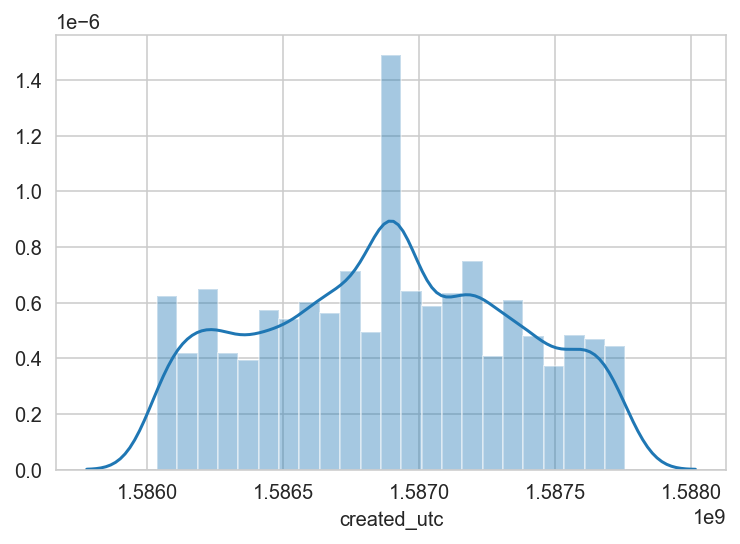

In [58]:
sns.distplot(physics_coms['created_utc'], kde = True)

In [56]:
chemistry_coms.dtypes

author             object
author_fullname    object
body               object
created_utc         int64
id                 object
parent_id          object
permalink          object
score               int64
subreddit          object
post_type          object
dtype: object

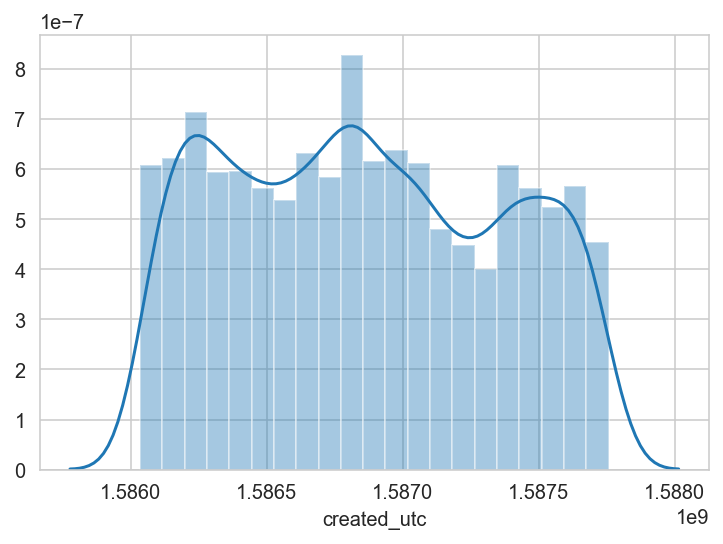

In [57]:
sns.distplot(chemistry_coms['created_utc'], kde = True)